# Zadání I. seminární práce z předmětu Počítačové zpracování signálu (KI/PZS)

## 2. Výpočet korelace měřených signálů 

In [11]:
# Importy
import wfdb
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import detrend, resample, correlate
from scipy.interpolate import interp1d
from scipy.stats import pearsonr
import pandas as pd

# Nacteni 
file_path = "C:\\Users\\Meter\\Desktop\\KI_PZS_Seminarky\\charis-database-1.0.0\\charis-database-1.0.0"
record = wfdb.rdrecord(file_path + "\\charis6")
fs = record.fs
signals = record.p_signal
channel_names = record.sig_name


print("Channels:", channel_names)
print("Sampling rate:", fs, "Hz")

Channels: ['ABP', 'ECG', 'ICP']
Sampling rate: 50 Hz


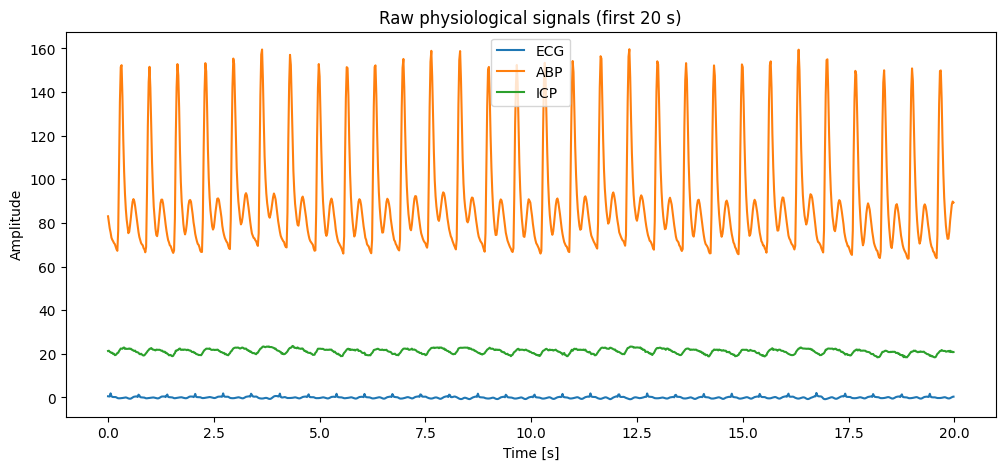

In [12]:
abp = signals[:, 0]
ecg = signals[:, 1]
icp = signals[:, 2]

t = np.arange(len(ecg)) / fs

plt.figure(figsize=(12, 5))
plt.plot(t[:fs*20], ecg[:fs*20], label='ECG')
plt.plot(t[:fs*20], abp[:fs*20], label='ABP')
plt.plot(t[:fs*20], icp[:fs*20], label='ICP')
plt.title('Raw physiological signals (first 20 s)')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

Tady předzpracovávám signál tak, že beru pouze první hodinu záznamu, nahrazuji chybějící hodnoty interpolací, provádím detrendování a centralizaci a případně jej převzorkuji na společnou vzorkovací frekvenci.

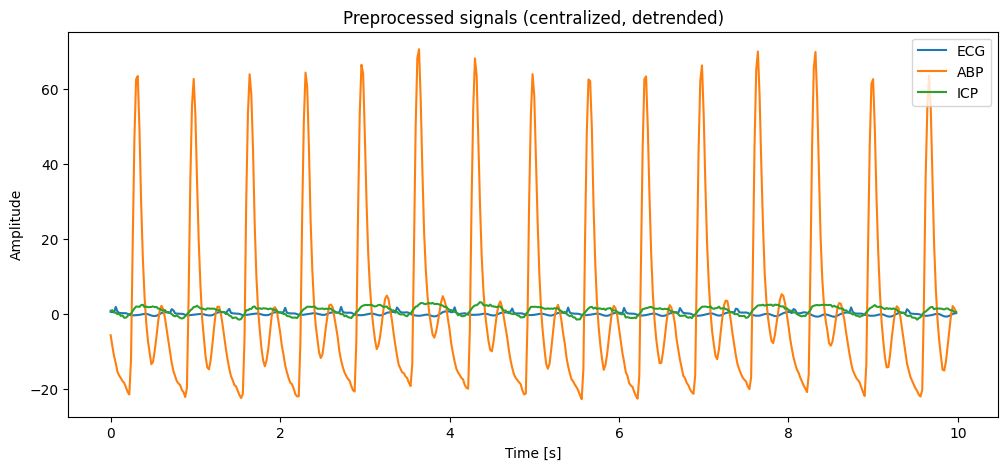

In [13]:
def preprocess(signal, fs, new_fs=None):
    
    signal = signal[:int(fs * 3600)]

    if np.isnan(signal).any():
        idx = np.arange(len(signal))
        mask = ~np.isnan(signal)
        f = interp1d(idx[mask], signal[mask], bounds_error=False, fill_value="extrapolate")
        signal = f(idx)

    
    signal = detrend(signal)
    signal = signal - np.mean(signal)

   
    if new_fs and new_fs != fs:
        new_len = int(len(signal) * new_fs / fs)
        signal = resample(signal, new_len)
        fs = new_fs

    return signal, fs


ecg, fs = preprocess(ecg, fs)
abp, fs = preprocess(abp, fs)
icp, fs = preprocess(icp, fs)


plt.figure(figsize=(12, 5))
t = np.arange(len(ecg)) / fs
plt.plot(t[:fs*10], ecg[:fs*10], label='ECG')
plt.plot(t[:fs*10], abp[:fs*10], label='ABP')
plt.plot(t[:fs*10], icp[:fs*10], label='ICP')
plt.title('Preprocessed signals (centralized, detrended)')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

Výpočet korelačního koeficientu pomocí Pearson a Cross-Correlation metodu


In [14]:
def compute_pairwise_correlations(ecg, abp, icp):
    r_ecg_abp, _ = pearsonr(ecg, abp)
    r_ecg_icp, _ = pearsonr(ecg, icp)
    r_abp_icp, _ = pearsonr(abp, icp)

    results = pd.DataFrame({
        'Signal pair': ['ECG–ABP', 'ECG–ICP', 'ABP–ICP'],
        'Correlation (r)': [r_ecg_abp, r_ecg_icp, r_abp_icp]
    })
    return results


corr_table = compute_pairwise_correlations(ecg, abp, icp)
display(corr_table)

,Signal pair,Correlation (r)
0,ECG–ABP,-0.403096
1,ECG–ICP,-0.370077
2,ABP–ICP,0.541123


V této části počítám křížovou korelaci mezi dvěma signály s různým časovým zpožděním, abych zjistil jejich maximální vzájemnou podobnost a odpovídající časový posun.

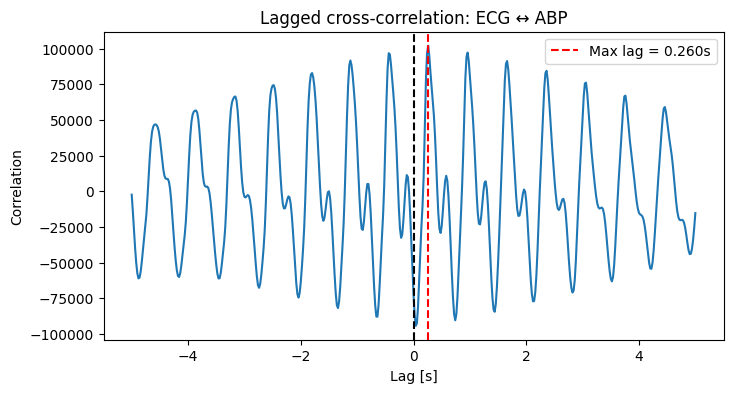

Maximum correlation = 0.566 at lag = 0.260 seconds


In [15]:
def lagged_cross_correlation(x, y, fs, max_lag_s=5):
  
    x = (x - np.mean(x)) / np.std(x)
    y = (y - np.mean(y)) / np.std(y)
    
    corr = correlate(y, x, mode='full')
    lags = np.arange(-len(x)+1, len(y))
    lags_sec = lags / fs

   
    mask = (lags_sec >= -max_lag_s) & (lags_sec <= max_lag_s)
    corr = corr[mask]
    lags_sec = lags_sec[mask]

    lag_max = lags_sec[np.argmax(corr)]
    corr_max = np.max(corr) / len(x)
    return lags_sec, corr, lag_max, corr_max


lags, corr_vals, lag_max, corr_max = lagged_cross_correlation(ecg, abp, fs, max_lag_s=5)

plt.figure(figsize=(8,4))
plt.plot(lags, corr_vals)
plt.axvline(0, color='k', linestyle='--')
plt.axvline(lag_max, color='r', linestyle='--', label=f'Max lag = {lag_max:.3f}s')
plt.title('Lagged cross-correlation: ECG ↔ ABP')
plt.xlabel('Lag [s]')
plt.ylabel('Correlation')
plt.legend()
plt.show()

print(f"Maximum correlation = {corr_max:.3f} at lag = {lag_max:.3f} seconds")

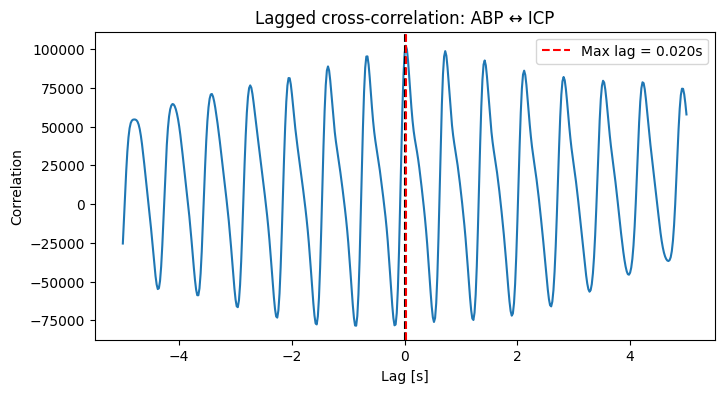

Maximum correlation = 0.568 at lag = 0.020 seconds


In [16]:
lags, corr_vals, lag_max, corr_max = lagged_cross_correlation(abp, icp, fs, max_lag_s=5)
plt.figure(figsize=(8,4))
plt.plot(lags, corr_vals)
plt.axvline(0, color='k', linestyle='--')
plt.axvline(lag_max, color='r', linestyle='--', label=f'Max lag = {lag_max:.3f}s')
plt.title('Lagged cross-correlation: ABP ↔ ICP')
plt.xlabel('Lag [s]')
plt.ylabel('Correlation')
plt.legend()
plt.show()
print(f"Maximum correlation = {corr_max:.3f} at lag = {lag_max:.3f} seconds")

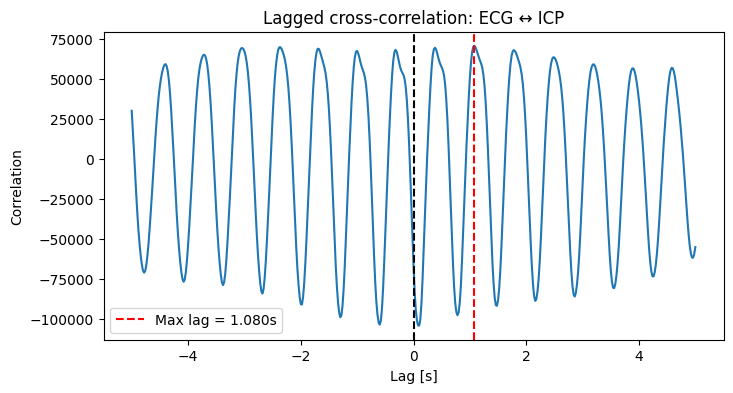

Maximum correlation = 0.395 at lag = 1.080 seconds


In [17]:
lags, corr_vals, lag_max, corr_max = lagged_cross_correlation(ecg, icp, fs, max_lag_s=5)
plt.figure(figsize=(8,4))
plt.plot(lags, corr_vals)
plt.axvline(0, color='k', linestyle='--')
plt.axvline(lag_max, color='r', linestyle='--', label=f'Max lag = {lag_max:.3f}s')
plt.title('Lagged cross-correlation: ECG ↔ ICP')
plt.xlabel('Lag [s]')
plt.ylabel('Correlation')
plt.legend()
plt.show()
print(f"Maximum correlation = {corr_max:.3f} at lag = {lag_max:.3f} seconds")

Zde načítám signály všech pacientů (ECG, ABP, ICP) a pro každého z nich následně počítám a ukládám výsledky křížové korelace mezi jednotlivými signály.

In [18]:
patients = ['charis1', 'charis2', 'charis3', 'charis4', 'charis5', 'charis6', 'charis7', 'charis8', 'charis9', 'charis10', 'charis11', 'charis12', 'charis13']

abp_signals = {}
ecg_signals = {}
icp_signals = {}

results_ecg = {}
results_abp = {}
results_icp = {}

for patient in patients:
    record = wfdb.rdrecord(file_path + f"\\{patient}")
    fs = record.fs
    signals = record.p_signal

    abp = signals[:, 0]
    ecg = signals[:, 1]
    icp = signals[:, 2]

    ecg, fs = preprocess(ecg, fs)
    abp, fs = preprocess(abp, fs)
    icp, fs = preprocess(icp, fs)

    abp_signals[patient] = abp
    ecg_signals[patient] = ecg
    icp_signals[patient] = icp

    lags_ecg_abp, corr_ecg_abp, lag_max_ecg_abp, corr_max_ecg_abp = lagged_cross_correlation(ecg, abp, fs, max_lag_s=5)
    results_ecg[patient] = (lag_max_ecg_abp, corr_max_ecg_abp)
    lags_abp_icp, corr_abp_icp, lag_max_abp_icp, corr_max_abp_icp = lagged_cross_correlation(abp, icp, fs, max_lag_s=5)
    results_abp[patient] = (lag_max_abp_icp, corr_max_abp_icp)
    lags_ecg_icp, corr_ecg_icp, lag_max_ecg_icp, corr_max_ecg_icp = lagged_cross_correlation(ecg, icp, fs, max_lag_s=5)
    results_icp[patient] = (lag_max_ecg_icp, corr_max_ecg_icp)

def create_results_table(results, signal_pair):
    data = {
        'Patient': [],
        'Max Lag (s)': [],
        'Max Correlation': []
    }
    for patient, (lag, corr) in results.items():
        data['Patient'].append(patient)
        data['Max Lag (s)'].append(lag)
        data['Max Correlation'].append(corr)
    df = pd.DataFrame(data)
    df.insert(0, 'Signal Pair', signal_pair)
    return df

table_ecg_abp = create_results_table(results_ecg, 'ECG–ABP')
table_abp_icp = create_results_table(results_abp, 'ABP–ICP')
table_ecg_icp = create_results_table(results_icp, 'ECG–ICP')
final_table = pd.concat([table_ecg_abp, table_abp_icp, table_ecg_icp], ignore_index=True)
display(final_table)

,Signal Pair,Patient,Max Lag (s),Max Correlation
0,ECG–ABP,charis1,0.00,0.030521
1,ECG–ABP,charis2,0.28,0.389341
2,ECG–ABP,charis3,0.92,0.171718
3,ECG–ABP,charis4,0.00,0.023756
4,ECG–ABP,charis5,0.00,0.023048
5,ECG–ABP,charis6,0.26,0.566420
6,ECG–ABP,charis7,0.30,0.326604
7,ECG–ABP,charis8,0.26,0.255417
8,ECG–ABP,charis9,0.58,0.147569
9,ECG–ABP,charis10,0.02,0.304985


Tady zas načítám a předzpracovávám ABP signály všech pacientů a následně mezi nimi počítám párové korelace, které ukládám do korelační matice.

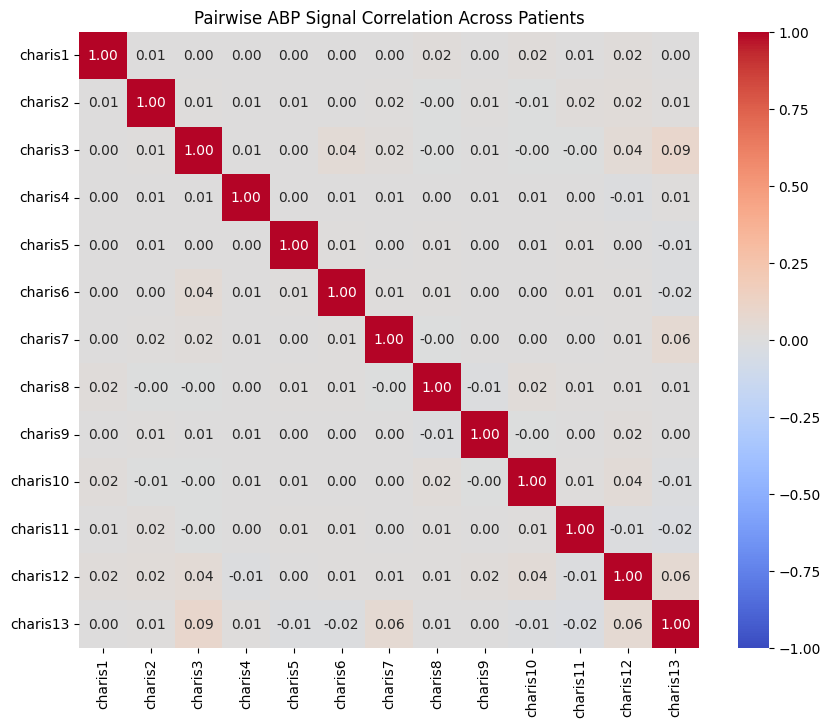

In [19]:
patients = ['charis1', 'charis2', 'charis3', 'charis4', 'charis5', 'charis6', 'charis7', 'charis8', 'charis9', 'charis10', 'charis11', 'charis12', 'charis13']

abp_signals = {}
for patient in patients:
    record = wfdb.rdrecord(f"{file_path}\\{patient}")
    abp = record.p_signal[:, 0]
    abp, _ = preprocess(abp, record.fs)
    abp_signals[patient] = abp

N = len(abp_signals)
corr_matrix = np.zeros((N, N))
for i, p1 in enumerate(patients):
    for j, p2 in enumerate(patients):
        _, corr_max = lagged_cross_correlation(abp_signals[p1], abp_signals[p2], fs, max_lag_s=5)[2:4]
        corr_matrix[i, j] = corr_max

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, xticklabels=patients, yticklabels=patients, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Pairwise ABP Signal Correlation Across Patients')
plt.show()



U pacientů s traumatickým poraněním mozku (TBI) má vztah mezi arteriálním krevním tlakem (ABP) a intrakraniálním tlakem (ICP) významný diagnostický potenciál, protože porucha mozkové autoregulace nebo změny intrakraniální poddajnosti mohou ovlivnit jak sílu, tak časování těchto korelací. Detekovaná zpoždění tak nejen potvrzují správnou synchronizaci signálů, ale zároveň poskytují vhled do opožděné hemodynamické odpovědi poraněného mozku.
